In [1]:
import numpy as np
from collections import OrderedDict
from copy import deepcopy

import ipywidgets as widgets
import matplotlib.pyplot as plt

import torch

import cooper

In [2]:
class Convex2dCMP(cooper.ConstrainedMinimizationProblem):
    def __init__(self, is_constrained=False, epsilon=1.0):
        self.epsilon = epsilon
        super().__init__(is_constrained)

    def closure(self, params):
        """This function evaluates the objective function and constraint
        defect. It updates the attributes of this CMP based on the results."""

        x = params[:, 0]
        y = params[:, 1]

        f = (1 - torch.sin(x)) * (1 + y**2)
        g = (1 - torch.cos(x)) * (1 + y**2)
        _ineq_defect = g - self.epsilon  # in standard form (defect <= 0)

        # Store the values in a CMPState as attributes
        state = cooper.CMPState(loss=f, ineq_defect=_ineq_defect, misc={"g": g})

        return state

In [34]:
OPTIM_DICT = {
    "SGD": cooper.optim.SGD,
    "Adam": cooper.optim.Adam,
    "Adagrad": cooper.optim.Adagrad,
    "RMSprop": cooper.optim.RMSprop,
}

# TODO: matplotlib style template
# TODO: add a button to reset the parameters


class Toy2DWidget(widgets.HBox):
    def __init__(self):

        super().__init__()

        # Initialize the CMP and its formulation
        self.cmp = Convex2dCMP(is_constrained=True)
        self.formulation = cooper.LagrangianFormulation(self.cmp)

        # Initialize the figure
        _, (self.xy_axis, self.loss_defect_axis) = plt.subplots(2, figsize=(8, 8))

        # Plot the loss contours. Done once as loss does not change with sliders.
        # The feasible set does change and is plotted in self.update.
        self.contour_params = self.loss_contours()

        # Plot the pareto front.
        self.pareto_front()

        # Run update to solve the CMP on the default hyper-parameters
        self.update(
            x=0.25,
            y=1.5,
            epsilon=0.7,
            primal_optim="SGD",
            dual_optim="SGD",
            primal_lr=5e-3,
            dual_lr=5e-3,
            dual_restarts=False,
        )

    def update(
        self, x, y, epsilon, primal_optim, primal_lr, dual_optim, dual_lr, dual_restarts
    ):

        # If epsilon was updated, do
        if epsilon != self.cmp.epsilon:
            self.update_feasible_set(epsilon=epsilon)

        # Reset the state of cmp and formulation
        self.reset_problem(epsilon=epsilon)

        params = torch.nn.Parameter(torch.tensor([[x, y]]))

        # Construct a new optimizer
        self.update_optimizer(
            params=params,
            primal_optim=primal_optim,
            dual_optim=dual_optim,
            primal_kwargs={"lr": primal_lr},
            dual_lr=dual_lr,
            dual_restarts=dual_restarts,
        )

        state_history = self.train(params=params)
        self.update_trayectory(state_history, epsilon)

        plt.show()

    def reset_problem(self, epsilon=None):
        """Reset the cmp and formulation for new training loops."""

        # Reset the state of the CMP. Update epsilon if necessary.
        self.cmp.epsilon = epsilon
        self.cmp.state = None

        # Reset multipliers
        self.formulation.ineq_multipliers = None
        self.formulation.eq_multipliers = None

    def update_optimizer(
        self,
        params,
        primal_optim,
        dual_optim,
        primal_kwargs,
        dual_lr,
        dual_restarts,
    ):

        primal_optimizer = OPTIM_DICT[primal_optim](
            [params],
            **primal_kwargs,
        )
        dual_optimizer = cooper.optim.partial(
            OPTIM_DICT[dual_optim],
            lr=dual_lr,
        )

        self.constrained_optimizer = cooper.ConstrainedOptimizer(
            formulation=self.formulation,
            primal_optimizer=primal_optimizer,
            dual_optimizer=dual_optimizer,
            dual_restarts=dual_restarts,
        )

    def train(self, params):
        """Train."""

        # Store CMPStates and parameter values throughout the optimization process
        state_history = OrderedDict()

        for iter in range(2000):
            self.constrained_optimizer.zero_grad()
            lagrangian = self.formulation.composite_objective(self.cmp.closure, params)
            self.formulation.custom_backward(lagrangian)
            self.constrained_optimizer.step()
            params[:, 0].data.clamp_(min=0, max=np.pi / 2)
            params[:, 1].data.clamp_(min=0)

            state_history[iter] = {
                "loss": self.cmp.state.loss.item(),
                "defect": self.cmp.state.ineq_defect.item(),
                "dual": deepcopy(self.formulation.state()[0].data),
                "params": deepcopy(params.data),
            }

        return state_history

    def loss_contours(self):
        """Plot the loss contours."""
        # Initial contours for plot
        x_range = torch.tensor(np.linspace(0, np.pi / 2, 100))
        y_range = torch.tensor(np.linspace(0, 2.0, 100))
        grid_x, grid_y = torch.meshgrid(x_range, y_range)

        grid_params = torch.stack([grid_x.flatten(), grid_y.flatten()], axis=1)
        all_states = self.cmp.closure(grid_params)
        loss_grid = all_states.loss.reshape(len(x_range), len(y_range))

        # Plot the contours
        CS = self.xy_axis.contour(
            grid_x,
            grid_y,
            loss_grid,
            levels=[0.05, 0.125, 0.25, 0.5, 1, 1.5, 2.0, 3.0],
            alpha=0.6,
            cmap="viridis",
        )

        # Add styling
        self.xy_axis.clabel(CS, inline=1, fontsize=10)

        g_grid = all_states.misc["g"].reshape(len(x_range), len(y_range))
        return {
            "grid_x": grid_x,
            "grid_y": grid_y,
            "grid_params": grid_params,
            "g_grid": g_grid,
        }

    def pareto_front(self):
        """Plot the pareto front in the loss vs defect plane. This part is done
        once."""
        # y parametrizes distance to front. Regardless of epsilon, y=0 poses a
        # non-dominated solution. x parametrizes the position on the pareto front.
        x_range = torch.tensor(np.linspace(0, np.pi / 2, 100))
        y_range = torch.tensor(100 * [0.0])
        all_states = self.cmp.closure(torch.stack([x_range, y_range], axis=1))
        self.loss_defect_axis.plot(
            all_states.loss, all_states.misc["g"].squeeze(), c="gray", alpha=0.5
        )

        # Add styling
        self.loss_defect_axis.set_xlabel("Objective")
        self.loss_defect_axis.set_ylabel("Constraint")
        # TODO: make plot symetric

    def update_trayectory(self, state_history, epsilon):

        # Unpack the state history
        iters, loss_hist, defect_hist, params_hist, mult_hist = zip(
            *[
                (iter_num, _["loss"], _["defect"], _["params"], _["dual"])
                for (iter_num, _) in state_history.items()
            ]
        )

        # Multiplier, loss and defect history
        # TODO: add plot

        # Trajectory in x-y plane
        # purge previous trajectory
        params_hist = np.stack(params_hist).squeeze()
        self.xy_axis.scatter(params_hist[:, 0], params_hist[:, 1], c="r", s=10)
        self.xy_axis.scatter(params_hist[-1, 0], params_hist[-1, 1], marker="*", s=100)

        # Trajectory in loss-defect plane
        g = epsilon + np.stack(defect_hist).squeeze()
        self.loss_defect_axis.scatter(loss_hist, g, s=2, c="red")
        self.loss_defect_axis.scatter(loss_hist[-1], g[-1], marker="*", s=100)

    def update_feasible_set(self, epsilon):
        """Plot the feasible set."""
        # the values of g(x, y) have been computed in self.loss_contours for
        # the whole grid. The feasibility boundary changes based on the epsilon
        self.xy_axis.contourf(
            self.contour_params["grid_x"],
            self.contour_params["grid_y"],
            self.contour_params["g_grid"],
            levels=[-10, epsilon],
            colors="blue",
            alpha=0.1,
        )

        # In loss vs defect plane, a line is drawn at the epsilon value
        self.loss_defect_axis.axhline(epsilon, c="gray", alpha=0.2, linestyle="--")

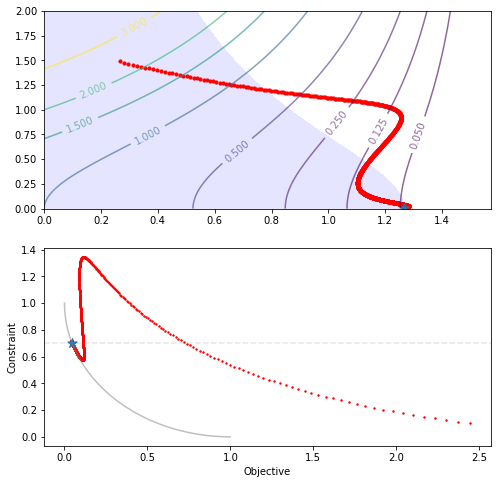

In [35]:
w = Toy2DWidget()